<a href="https://colab.research.google.com/github/Leitemfa/GromovMatcher/blob/main/GM_MyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GromovMatcher: Optimal transport for automatic alignment of untargeted metabolomic data

This is how I used the example script to run GromovMatcher on untargeted data from two datasets I have.

Untargeted data must was preprocessed before hand and be in the form of two feature tables similar to the toy dataset provided in toy_data.

-------

## Loading the Anaconda environment

All my analysis are done in the conda environment and I also want to use it in SLURM to be able to run another version of the same data with larger datasets

### STEP 1: IMPORT GROMOVMATCHER

Main functions for GromovMatcher (GM) are the 'src' folder. Make sure to either have it in your working directory or to update the path.

In [ ]:
import src.main_GromovMatcher_function as GromovMatcher

### STEP 2: LOAD AND FORMAT THE DATA

GM accepts as input 2 feature tables (samples in rows, features in columns) formatted as follows:
- Row 0: m/z of the features. Units must be compatible.
- Row 1: RTs of the features. They can be in different units.
- Subsequent rows: intensity vectors.

Feature tables must be supplied as numpy arrays. Integration of pandas dataframes to included feature IDs will be implemented in the future.

#### <u>Toy datasets are provided as an example.
    
They are randomly generated from a subset of the EXPOsOMICs LC-MS dataset used for our simulation study, with an overlap of 0.6. They comprise 499 samples and 399 features each, with an expected overlap of around 300 features.

Load toy datasets:

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
Data1 = pd.read_csv('toy_data/dataset1.csv', index_col = 0)
Data1.head()

feature_1   feature_2   feature_3   feature_4   feature_5  \
m/z       465.356100  328.119800  167.095500  328.046500  851.757600   
RT          6.535379    6.182612    6.612022    5.585265    0.578971   
sample_1    9.423911   11.137338    8.750625   10.816653   11.048638   
sample_2    9.573575   10.619259   10.051474    9.937789    9.835425   
sample_3    9.784057    9.422400    8.030211   10.592899    9.816718   

           feature_6   feature_7   feature_8   feature_9  feature_10  ...  \
m/z       626.450600  198.048700  280.072400  210.088300  575.374400  ...   
RT          7.279726    2.686471    4.843802    3.150286    6.593270  ...   
sample_1    9.680030    9.304109    8.676878   10.001277    9.087929  ...   
sample_2   11.046153    8.452906    9.622708   11.218898   11.726646  ...   
sample_3   10.197378   10.463433    9.664574   10.577018    9.559258  ...   

          feature_390  feature_391  feature_392  feature_393  feature_394  \
m/z        440.766800   816.456300    85.950600   311.007700   266.102600   
RT           7.251791     6.867382     0.492172     2.095689     4.845570   
sample_1     8.156194    10.535589    10.198177    10.266100     8.974429   
sample_2    10.181159     9.856329     7.408888     9.573193    10.230746   
sample_3    10.119167     7.594174     9.214957     9.119060     9.775849   

          feature_395  feature_396  feature_397  feature_398  feature_399  
m/z         96.057800   168.077100   375.768800   401.277100   502.218900  
RT           3.607805     4.389801     7.266612     6.424646     5.970378  
sample_1     9.453206    10.936373     9.026506     8.833992     8.767282  
sample_2     9.485478     9.854851     8.266503     9.646424    11.335629  
sample_3     9.165069    10.236783     8.665747    10.045545     9.541500  

[5 rows x 399 columns]

In [ ]:
Data2 = pd.read_csv('toy_data/dataset2.csv', index_col = 0)
Data2.head()

feature_1   feature_2   feature_3   feature_4   feature_5  \
m/z       713.474275  349.206278  294.227984  306.196737  300.244176   
RT          5.730765    4.098561    6.174664    3.538476    4.989352   
sample_1   11.248834    8.384104    9.896224   10.977128    7.617398   
sample_2   10.545851    8.769643    9.198931    8.727798    9.306075   
sample_3   10.968538    9.200432   10.641560    9.381849    9.540197   

           feature_6   feature_7   feature_8   feature_9  feature_10  ...  \
m/z       399.034364  317.994540  445.163117  205.124345  945.744139  ...   
RT          5.398298    0.577044    4.787751    3.079376    0.606640  ...   
sample_1    9.840186    9.542567    8.960789    9.312926   11.535990  ...   
sample_2   10.424690    9.067920    7.582651    8.154840    9.685585  ...   
sample_3    9.694744   11.032554    8.277138    8.727093   10.903483  ...   

          feature_390  feature_391  feature_392  feature_393  feature_394  \
m/z        574.374124   145.050869   971.764448   510.333673   634.306314   
RT           5.585969     2.673242     1.034292     5.492019     5.429711   
sample_1     7.157606     8.708465     8.890690     9.792387     9.443509   
sample_2     9.045645     9.044384    10.748547     9.414450     9.559016   
sample_3    10.006739    10.301322     9.308430     9.964429     9.651942   

          feature_395  feature_396  feature_397  feature_398  feature_399  
m/z        227.109999   794.370793   429.098501   809.777973   155.102351  
RT           5.055951     5.270326     2.766335     0.854892     2.568450  
sample_1    10.175153     9.371118     8.507801    10.389550    11.677518  
sample_2    10.064462     9.487400     9.988619     9.812783    10.979987  
sample_3     9.405956     9.944155     8.912474    11.249274    11.993833  

[5 rows x 399 columns]

The data is formatted for GM, and just needs to be converted to numpy arrays.

Some important points:

- GM does NOT check whether the samples in Data1 and Data2 are similar. Therefore we advise to make sure that the sample populations are as similar as possible across both datasets. For instance, for matched case/control studies, we advise to exclude the samples corresponding to cases if the sample size allows it.
- If you expect the populations to be different, we advise to center and scale the feature intensities to have mean of 0 and std of 1 before launching GM.

### STEP 3: LAUNCH GROMOVMATCHER

Launch GM's main function on the toy datasets with default parameters. Runtime depends on the feature size and is typically on the order of minutes.

The output is a numpy array of size (features in Data1, features in Data2)

In [ ]:
default_coupling = GromovMatcher.GM(np.array(Data1), np.array(Data2))

GM identified pairs correspond to non-zeros coefficients in the coupling matrix. The output of GM is not a matching matrix by default, meaning that it can have more than one non-zero coefficient per row and/or column.

In [ ]:
np.sum(default_coupling > 0)

322

Here, the raw coupling matrix contains 322 non zero coefficients, i.e. potential pairs. Multiple matches are still present, for exploratory purposes.

In [ ]:
one_to_one_coupling = GromovMatcher.keep_max(default_coupling)
np.sum(one_to_one_coupling > 0)

300

The number of pairs detected is down to 300 after excluding the lowest scored ones.

GM has some tunable parameters listed below:

Computation-related parameters:

- mgap (default = 0.01), GM's m/z tolerance. Features with an m/z difference of more than mgap will not be matched.
- K_outliers (default = 2), number of filtering iterations performed during the RT drift estimation. In order to smooth out the estimated drift, K_outliers filtering steps are carried out, estimating the RT drift and removing outlying pairs.
- RT_filter (default = 'MAD'), GM's final criterion for filtering out outliers once the RT drift is estimated. Possible values are 'MAD' (mean absolute deviation), 'MSE' (mean squared error), 'hard_thr' (fixed threshold around the estimated drift). Can be set to None to output unfiltered raw coupling.

Visualization/QC-related parameters

- verbose (bool)
- plot_list, list of elements you want to plot (numpy array containing included in ['Distance patterns', 'Weights', 'Coupling','RT drift','Outliers'])</br>
Distance patterns, Weights and Coupling mainly serve verification purpose. Plot heatmaps of, respectively, the distance matrices of each dataset (of respective size (p1,p1) and (p2,p2)), the weight matrix (of size (p1,p2), containing the weights used in the computation of the Gromov-Wasserstein distance), the raw coupling matrix (of size (p1,p2), containing the coupling coefficients before RT filtering).</br>
RT drifts plot the final RT deviation estimated during the GromovMatcher process. Outliers outputs *K_outliers* plot, one for each iteration of the filtering pocess, representing the RT drfit as estimated during that step and the outliers subsequently discarded.

Here is an example of the visualisation tools provided by GromovMatcher. The command above plots the estimated RT drift and saves it in the current working directory.

Checking arguments:

Using default distance matrices.
Matching will be computed using GW cost only.
Restricting GW to m/z compatible pairs, using mgap = 0.01
Estimating RT deviation and filtering. Filtered coupling will be returned.


Going ahead with the GW-based coupling:

Default normalized euclidian distance matrices computed.
Default weights computed.
Matching cost is set to Gromov-Wasserstein only.
GW coupling successfully computed.
344 pairs recovered in the crude coupling.

Estimating RT deviation with model = True :
Done.

Filtering the crude coupling based on the estimated RT deviation:
Done.
322 pairs in the filtered coupling.


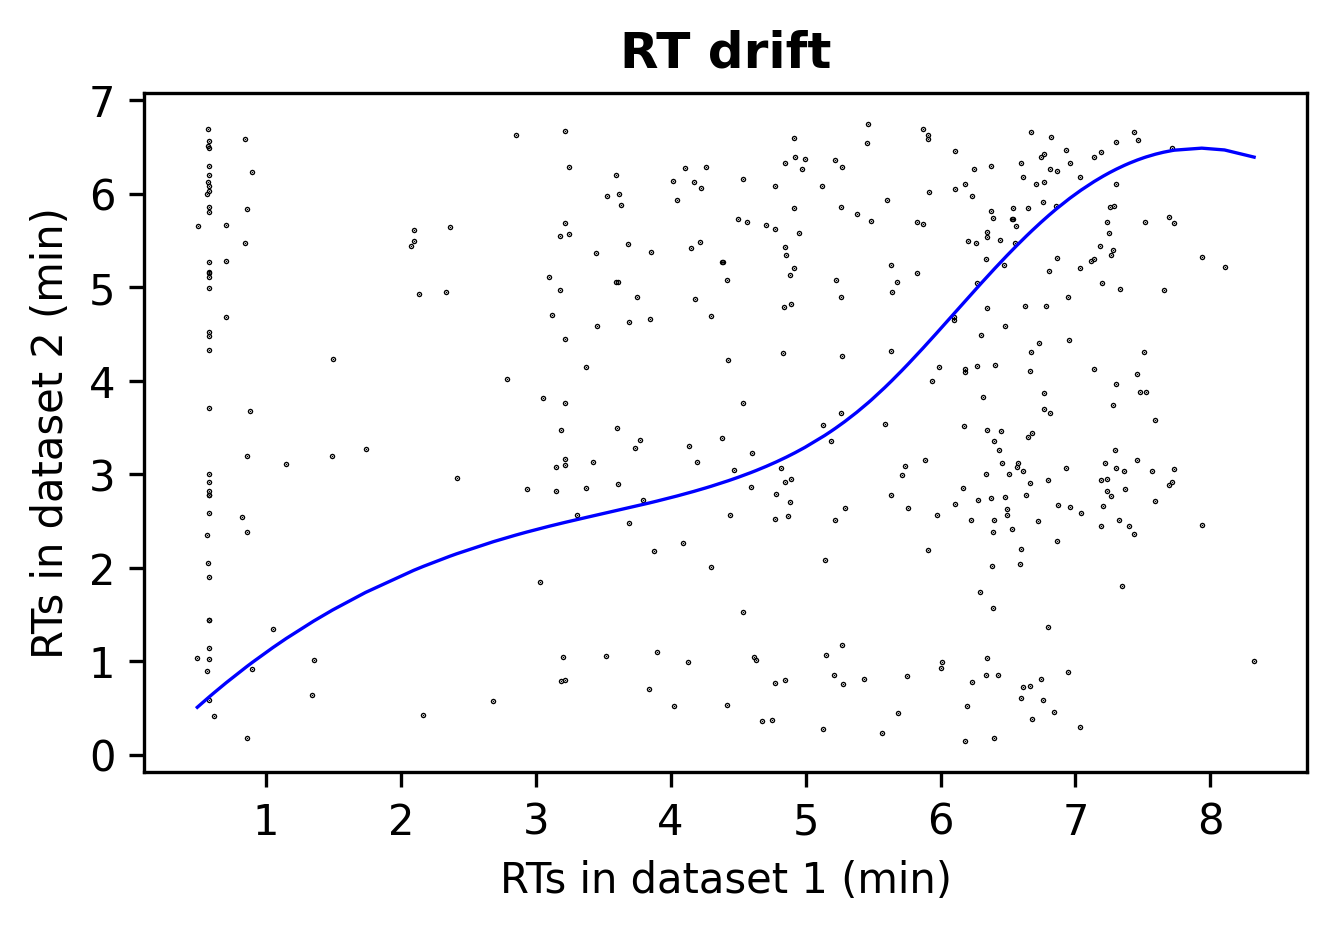

In [ ]:
RTplot_coupling = GromovMatcher.GM(np.array(Data1), np.array(Data2), verbose = True, plot_list = ['RT drift'], plot_path = '')

 Other, more exploratory arguments to GromovMatcher.

 - The *lmbda*, *otcost* and *mu* arguments modify the cost function, going from (weighted) Gromov-Wasserstein alone to a mixture of Gromov-Wassertein distance on the feature intensities and regular OT cost on the m/z and RT, following Zheng et al. (https://doi.org/10.1137/19M1253976). *lmbda* is the strength of the mixture, between 0 and 1. 0 is the default value and corresponds to the (weighted) Gromov-Wasserstein distance alone, while 1 falls back to regular OT on the m/z and RT alone, without making use of the correlation patterns. *ot_cost* and *mu* determine how the OT cost on the m/z and RT should be computed (see documentation of the GM function for more information).
 - The *D1* and *D2* arguments are set to None by default (which indicate the use of the default euclidean distance between the features) but can accomodate custom distance matrices (numpy arrays of respective sizes (p1,p1) and (p2,p2)).
 - the *w* argument determines how the weights are computed in the Gromov-Wasserstein distance computation. Default is 'm/z', corresponds to heavily weighting pairs with a m/z difference exceeding the mgap threshold. None reverts to regular unweighted Gromov-Wasserstein (can be used for instance in case where *lmbda* is non zero and the m/z are accounted for in the OT cost). Custom weights can also be provided in the form of a (p1,p2) numpy array.

 - RT related arguments (*RT_pred*, *RT_fit*, *RT_filter* and *RT_thr*) are detailed in the GromovMatcher documentation. The determine whether and how to estimate the RT drift, whether to filter the coupling based on the estimation, and how to detect outliers. Default settings are True, 'all', 'MAD', and None respectively

### STEP 4: REFORMAT THE COUPLING INTO A LIST

GromovMatcher.GM returns the (p1,p2) coupling matrix, but many applications require a more legibl output. The *link_features* function transforms the coupling matrix into a list of matched pairs, with their associated coupling coefficient.

In [ ]:
pair_list = GromovMatcher.link_feature(Data1, Data2,one_to_one_coupling)

In [ ]:
pair_list

0
feature_29  feature_94   0.611724
feature_53  feature_261  0.711670
feature_101 feature_205  0.993741
feature_102 feature_52   0.711463
feature_103 feature_155  0.985525
...                           ...
feature_395 feature_43   0.988397
feature_396 feature_66   0.899134
feature_397 feature_23   0.976297
feature_398 feature_69   0.971402
feature_399 feature_191  0.995423

[300 rows x 1 columns]